In [37]:
import pandas as pd
import numpy as np
import os
import typing
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

from tensorflow.keras.regularizers import l2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.utils import plot_model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError, MeanSquaredLogarithmicError

from spektral.data.loaders import SingleLoader, DisjointLoader, BatchLoader
from spektral.datasets.citation import Citation
from spektral.layers import GATConv, DiffusionConv, GCNConv
from spektral.transforms import LayerPreprocess

from extraction.extract import *
from extraction.extractionvalues import *
from extraction.extractadjacency import getAdjacencyMatrix, distance_weight_adjacency
# from extraction.adj_data import *

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
%load_ext tensorboard
# %tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [38]:
tf.config.list_physical_devices("GPU")


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [39]:
airportsFull = ICAOTOP50
airports = airportsFull[::]
airports.remove("LTFM")  # removing the new istanbul airport as it opened mid-2019

n_nodes = n_airports = len(airports)
start = datetime(2018, 3, 1)
end = datetime(2019, 7, 1)
timeslotLength = 30

# Run settings
batch_size = 64
epochs = 100
patience = 5
lookback = 8
lookahead = 6
multi_horizon = True

learning_rate = 0.0001
# learning_rate = 0.0005
# learning_rate = 0.05

# runName = "top50MSE"
saveModel = True
loadModel = False
# modelSaveFolder = "kerasModels/"
# modelSaveLocation = modelSaveFolder + runName


Load Data

In [40]:
dataDict = generateNNdataMultiple(
    airports, timeslotLength, GNNFormat=True, start=start, end=end, disableWeather=True
)

100%|██████████| 49/49 [00:02<00:00, 18.27it/s]


In [41]:
# we remove some of the most uncorrelated features
columnsToDrop = [
    "weekend",
    "winter",
    "spring",
    "summer",
    "autumn",
    "night",
    "morning",
    "afternoon",
    "planes",
    "arrivalsDepartureDelay",
    "evening"
]

Xlist = []
Ylist = []

# scaler = MinMaxScaler(feature_range=(-1, 1))
# scaler = RobustScaler()
for airport in airports:
    # T x F
    X = dataDict[airport]["X"].drop(columnsToDrop, axis=1)
    # X = scaler.fit_transform(X)
    Y = dataDict[airport]["Y"].iloc[:, :]
    # T = dataDict[airport]["T"].iloc[:, :]


    # Adding back delay as a feature
    # We shift the delay features back by one to prevent dataleaks.
    a, b = X.iloc[1:,:].reset_index(drop=True), Y.iloc[:-1,:].reset_index(drop=True)

    X = pd.concat([a, b], axis=1)
    if airport == "EGLL":
        print(X.columns)
    Xlist.append(X.to_numpy())
    Ylist.append(Y.iloc[1:,:].to_numpy())


Xlist = np.stack(Xlist)
Ylist = np.stack(Ylist)
# N x T x F
Xarray = np.swapaxes(Xlist, 0, 1)
Yarray = np.swapaxes(Ylist, 0, 1)

# T x N x F

# # Normalise over the features
Xmean, Xstd = Xarray.mean(axis=0), Xarray.std(axis=0)
Xarray = (Xarray - Xmean) / Xstd


print("T x N x F: ", "Xarray =", Xarray.shape, "|", "Yarray =", Yarray.shape)

nFeatures = Xarray.shape[2]

times = list(dataDict.values())[0]["T"].iloc[1::] # to match the reduced X and y


Index(['departing', 'arriving', 'lowcost', 'arrivalsFlightDuration',
       'departuresFlightDuration', 'capacityFilled', 'arrivalsArrivalDelay',
       'departuresDepartureDelay'],
      dtype='object')
T x N x F:  Xarray = (8783, 49, 8) | Yarray = (8783, 49, 2)


Adjacencies

In [42]:
distance_adj = distance_weight_adjacency(airports, threshold=400)
flight_adj = getAdjacencyMatrix(airports, start, end, timeslotLength)

Aarray = distance_adj * 0.4 + (1 - 0.4) * flight_adj
print(len(Aarray))

8784


In [43]:
train_split, val_split = 0.6, 0.25

fullLength = len(times)
train_idx = int(train_split * fullLength)
val_idx = int((val_split + train_split) * fullLength)
print(
    f"Train split: {0}:{train_idx} | Validation split: {train_idx}:{val_idx} | Test split: {val_idx}:{fullLength}"
)


# train_idx = train_idx-(train_idx%batch_size)
# val_idx = val_idx-((val_idx-train_idx)%batch_size)
# final = fullLength-((fullLength-val_idx)%batch_size)
# # val_idx = train_idx-(train_idx%batch_size)
# print(final)
# generate raw splits

print(Aarray.shape)
Xtrain, Xval, Xtest = Xarray[0:train_idx], Xarray[train_idx:val_idx], Xarray[val_idx:]
Ytrain, Yval, Ytest = Yarray[0:train_idx], Yarray[train_idx:val_idx], Yarray[val_idx:]
Atrain, Aval, Atest = Aarray[0:train_idx], Aarray[train_idx:val_idx], Aarray[val_idx:]
Ttrain, Tval, Ttest = times.iloc[0:train_idx], times.iloc[train_idx:val_idx], times.iloc[val_idx:]

# Save test timeslots for plotting purposes
testTimes = times.iloc[val_idx::, 0].tolist()

print("Train arrays len:", len(Xtrain), len(Ytrain), len(Atrain), len(Xtrain)%batch_size)
print("val arrays len:", len(Xval), len(Yval), len(Aval), len(Xval)%batch_size)
print("test arrays len:", len(Xtest), len(Ytest), len(Atest), len(Xtest)%batch_size)
print(len(Xtrain) + len(Xval) + len(Xtest))

print(Xtrain.shape)


Train split: 0:5269 | Validation split: 5269:7465 | Test split: 7465:8783
(8784, 49, 49)
Train arrays len: 5269 5269 5269 21
val arrays len: 2196 2196 2196 20
test arrays len: 1318 1318 1319 38
8783
(5269, 49, 8)


#### Custom new TF dataset

In [44]:
def createDataset(
    features_Array: np.ndarray,
    adjacencies_Array: np.ndarray,
    target_array:np.ndarray,
    lookback: int,
    lookahead: int,
    batch_size: int = 64,
    multi_horizon=True,
    shuffle_dates=True,
    times=None
):

    if shuffle_dates:
        # Shuffle days
        # basically i am shuffling a pandas df with the times and the original
        # indexes to then shuffle the other datasets with those indexes
        times = times.reset_index(drop=True) # make sure the index starts at 0
        
        times = times.reset_index() # get the original index
        # get the groups of date and shuffle them
        groups = [times for _, times in times.groupby(times.timeslot.dt.date)]
        random.shuffle(groups)

        # rejoin them and take out a list
        shuffledIndexes = pd.concat(groups).reset_index(drop=True)
        shuffledIndexes = shuffledIndexes["index"].tolist()

        #Shuffle data accordingly
        features_Array = features_Array[shuffledIndexes]
        adjacencies_Array = adjacencies_Array[shuffledIndexes]
        target_array = target_array[shuffledIndexes]


    # make windows
    idx=0
    Fsamples = []
    Asamples = []
    Ysamples = []

    while True:
        if len(features_Array[idx::]) < (lookback + lookahead):
            break

        # Features
        Fsample = features_Array[idx:idx+lookback,:,:]
        Fsamples.append(Fsample)

        # Adjacencies
        Asample = adjacencies_Array[idx:idx+lookback,:,:]
        Asamples.append(Asample)

        # make labels with multi-horizon
        if multi_horizon:
            Ysample = target_array[idx+lookback-1:idx+lookback+lookahead-1,:,:]
            Ysamples.append(Ysample)
        else:
            raise NotImplementedError("Non-mulit-horizon not been implemented")


        idx+=1

    features = np.array(Fsamples)
    adjacencies = np.array(Asamples)
    labels = np.array(Ysamples)

    # Ensure only complete batches are made (remove incomplete ones)
    batchCutoff = features.shape[0] - (features.shape[0] % batch_size)

    features, adjacencies, labels = features[:batchCutoff,:,:,:], adjacencies[:batchCutoff,:,:,:], labels[:batchCutoff,:,:,:]

    dataset = tf.data.Dataset.from_tensor_slices(((features,adjacencies), labels)).batch(batch_size)
    return dataset



        
train_dataset = createDataset(
    Xtrain,
    Atrain,
    Ytrain,
    lookback,
    lookahead,
    batch_size=batch_size,
    multi_horizon=multi_horizon,
    times=Ttrain
)
val_dataset = createDataset(
    Xval,
    Aval,
    Yval,
    lookback,
    lookahead,
    batch_size=batch_size,
    multi_horizon=multi_horizon,
    times=Tval
)
test_dataset = createDataset(
    Xtest,
    Atest,
    Ytest,
    lookback,
    lookahead,
    batch_size=batch_size,
    multi_horizon=multi_horizon,
    shuffle_dates=False,
    times=Ttest
)

print(train_dataset)

<BatchDataset shapes: (((None, 8, 49, 8), (None, 8, 49, 49)), (None, 10, 49, 2)), types: ((tf.float64, tf.float64), tf.float64)>


Model

In [56]:
# lookback = 8 # steps
l2_reg = 2.5e-4  # L2 regularization rate
# learning_rate = 2e-4  # Learning rate

channels = 10
attn_heads = 10
lstm_units = 60

num_labels = 2


In [57]:
x_in = layers.Input(shape=(lookback, n_nodes, nFeatures), batch_size=batch_size, name="Features")
a_in = layers.Input(shape=(lookback, n_nodes, n_nodes), batch_size=batch_size, name="Adjacencies")


x_inn = tf.reshape(x_in, (batch_size*lookback, n_airports, nFeatures))
a_inn = tf.reshape(a_in, (batch_size*lookback, n_airports, n_airports))

gatout = GATConv(
    channels=channels,
    attn_heads=attn_heads,
    kernel_regularizer=l2(l2_reg),
    attn_kernel_regularizer=l2(l2_reg),
    bias_regularizer=l2(l2_reg),
    name=f"GAT"
)([x_inn, a_inn])
print(gatout.shape)

reshape1 = tf.reshape(gatout, (batch_size, lookback, n_airports, attn_heads*channels))
print(reshape1.shape)
reshape1 = tf.transpose(reshape1, [0, 2, 1, 3])
print(reshape1.shape)
reshape1 = tf.reshape(reshape1, (batch_size*n_airports, lookback, attn_heads*channels))
print(reshape1.shape)


lstm1 = layers.LSTM(lstm_units, return_sequences=True, name="LSTM1")(reshape1)
lstm2 = layers.LSTM(lstm_units, return_sequences=False, name="LSTM2")(lstm1)
print(lstm2.shape)
dense1 = layers.Dense(lstm_units, name="Dense1")(lstm2)
print(dense1.shape)
dense2 = layers.Dense(num_labels * lookahead, name="DenseFinal")(dense1)
print(dense2.shape)

output = tf.reshape(dense2, (batch_size, n_nodes, lookahead, num_labels), name="ReshapeFinal")
# output = tf.reshape(dense2, (n_nodes, batch_size, lookahead, num_labels), name="ReshapeFinal")
print(output.shape)
output = tf.transpose(output, [0, 2, 1, 3], name="Re-orderToOutput")
# output = tf.transpose(output, [1, 2, 0, 3], name="Re-orderToOutput")
print(output.shape)


(512, 49, 100)
(64, 8, 49, 100)
(64, 49, 8, 100)
(3136, 8, 100)
(3136, 60)
(3136, 60)
(3136, 20)
(64, 49, 10, 2)
(64, 10, 49, 2)


In [58]:
model = keras.Model(inputs=[x_in, a_in], outputs=output, name="Tristan")

optimizer = Adam(learning_rate=learning_rate*10)
model.compile(
    optimizer=optimizer,
    loss=MeanSquaredError(reduction="auto", name="mean_absolute_error"),
    weighted_metrics=["acc"],
)

model.summary()
# plot_model(model, to_file='model.png')

Model: "Tristan"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Features (InputLayer)          [(64, 8, 49, 8)]     0           []                               
                                                                                                  
 Adjacencies (InputLayer)       [(64, 8, 49, 49)]    0           []                               
                                                                                                  
 tf.reshape_15 (TFOpLambda)     (512, 49, 8)         0           ['Features[0][0]']               
                                                                                                  
 tf.reshape_16 (TFOpLambda)     (512, 49, 49)        0           ['Adjacencies[0][0]']            
                                                                                            

In [59]:
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1
)
# reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=2, min_lr=learning_rate)

print(train_dataset.element_spec)

history = model.fit(
    # x = [train_dataset[0], train_dataset[1]],
    # y = train_dataset[2],
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",patience=patience),
        tensorboard_callback,
        # reduceLR
    ],
    shuffle=False
)

((TensorSpec(shape=(None, 8, 49, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None, 8, 49, 49), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 10, 49, 2), dtype=tf.float64, name=None))
Epoch 1/100
82/82 [==============================] - 19s 159ms/step - loss: 74.1764 - acc: 0.4914 - val_loss: 60.9992 - val_acc: 0.4826
Epoch 2/100
82/82 [==============================] - 12s 143ms/step - loss: 65.0654 - acc: 0.5068 - val_loss: 59.1670 - val_acc: 0.5050
Epoch 3/100
82/82 [==============================] - 12s 141ms/step - loss: 63.7547 - acc: 0.5383 - val_loss: 58.3961 - val_acc: 0.5283
Epoch 4/100
82/82 [==============================] - 12s 141ms/step - loss: 62.7516 - acc: 0.5581 - val_loss: 56.9628 - val_acc: 0.5363
Epoch 5/100
82/82 [==============================] - 12s 142ms/step - loss: 61.8146 - acc: 0.5629 - val_loss: 55.9322 - val_acc: 0.5311
Epoch 6/100
82/82 [==============================] - 12s 142ms/step - loss: 61.0485 - acc: 0.5685 - val_loss: 55.3698 - 

# Analysis


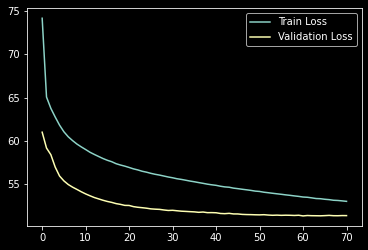

In [60]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [61]:
windowSize = 200  # 1-400
maxPlots = 10

forecastlen = 6  # 1-10
forecastlen = min(forecastlen, lookahead)
print(f"Hours ahead = {forecastlen / (60/timeslotLength)}")


Hours ahead = 3.0


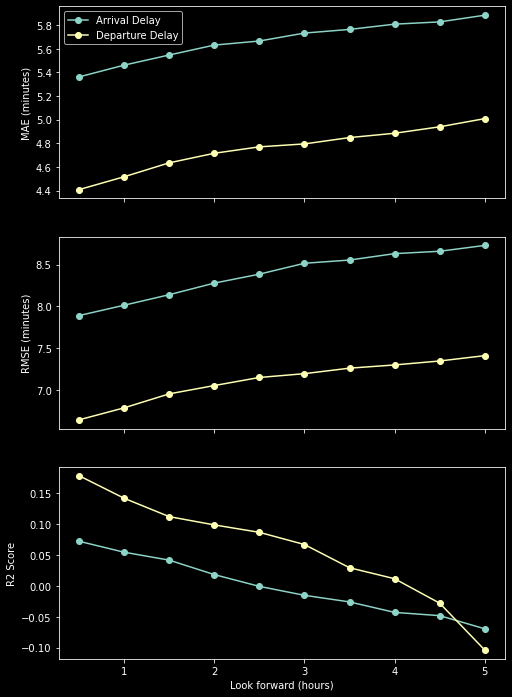

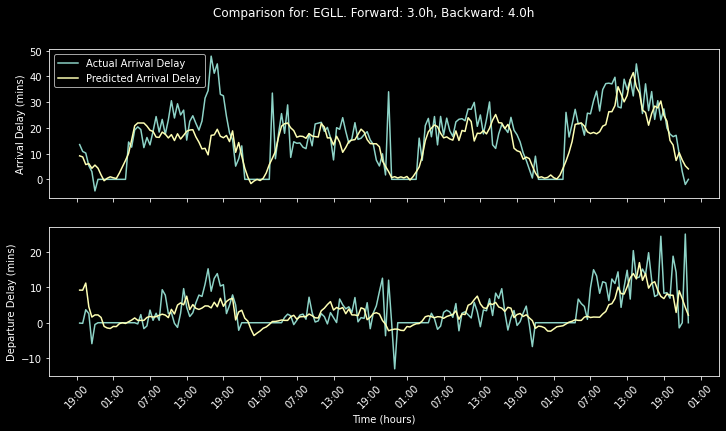

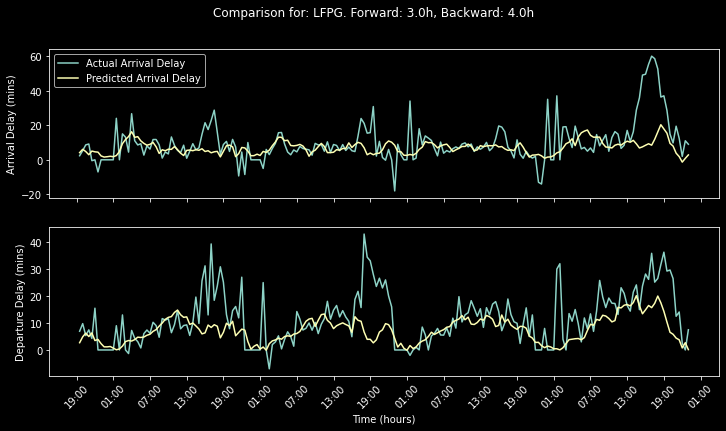

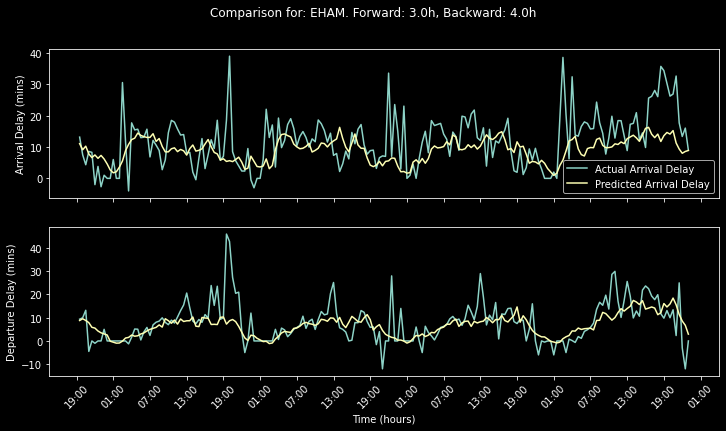

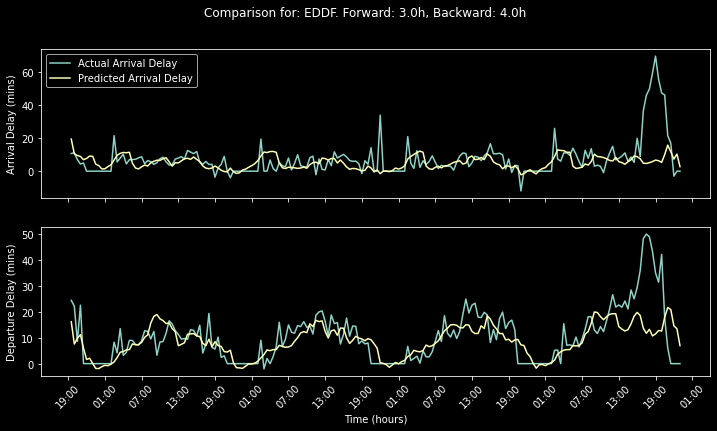

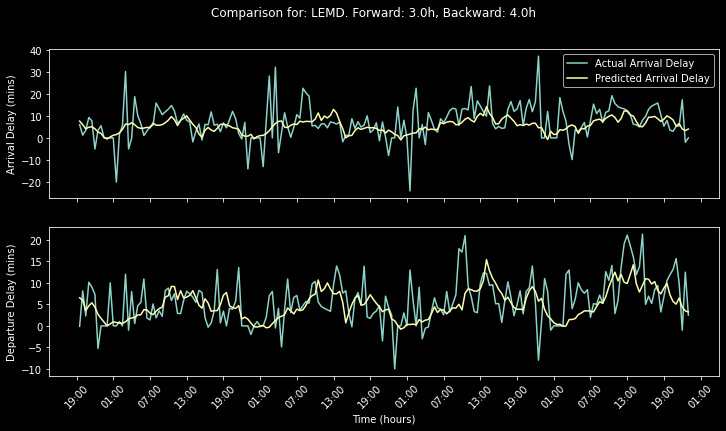

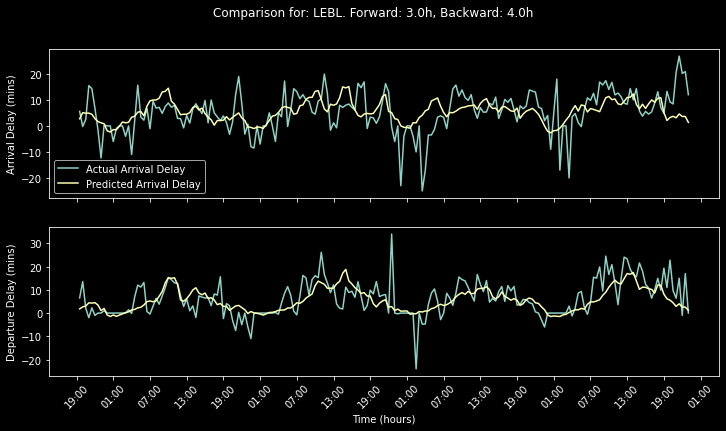

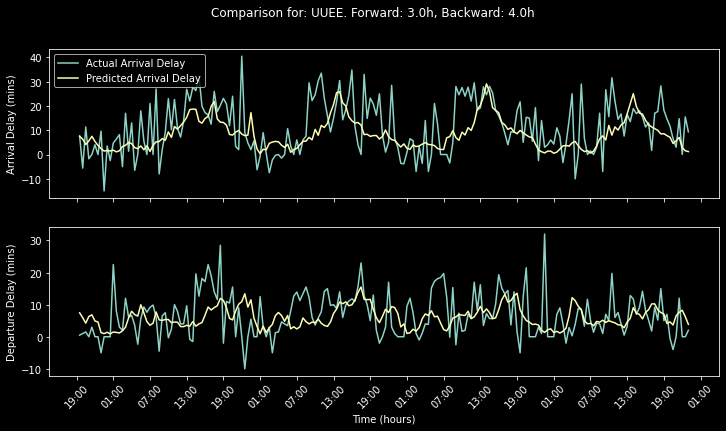

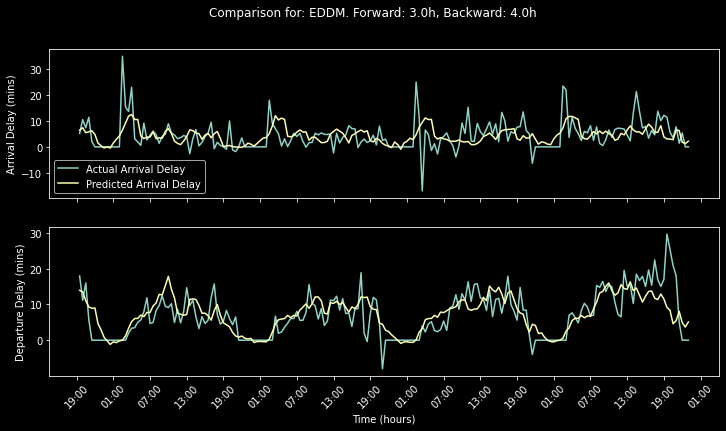

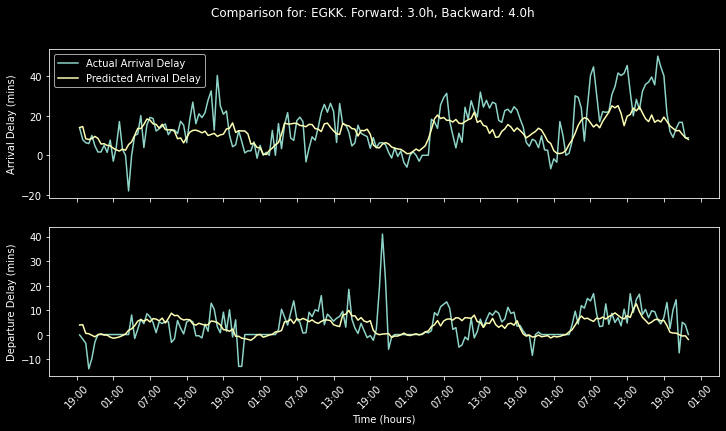

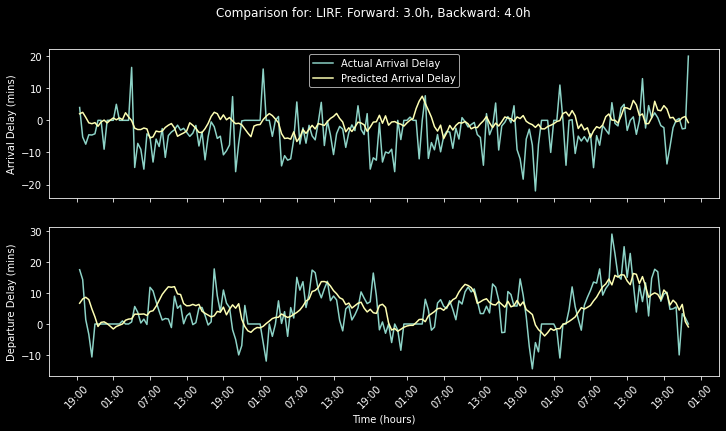

In [62]:
def getLabelArrays(hour, lookback=lookback):
    syncindex = lookback + hour - 1
    yTestPred = model.predict(test_dataset, verbose=0)
    ypredFull = yTestPred[:windowSize, hour - 1, :, :]
    yactualFull = Ytest[syncindex : windowSize + syncindex :, :]

    mae1 = mean_absolute_error(yactualFull[:, :, 0], ypredFull[:, :, 0])
    mae2 = mean_absolute_error(yactualFull[:, :, 1], ypredFull[:, :, 1])
    rmse1 = np.sqrt(mean_squared_error(yactualFull[:, :, 0], ypredFull[:, :, 0]))
    rmse2 = np.sqrt(mean_squared_error(yactualFull[:, :, 1], ypredFull[:, :, 1]))
    r2_1 = r2_score(yactualFull[:, :, 0], ypredFull[:, :, 0])
    r2_2 = r2_score(yactualFull[:, :, 1], ypredFull[:, :, 1])

    time = testTimes[syncindex : windowSize + syncindex :]
    return ypredFull, yactualFull, mae1, mae2, rmse1, rmse2, r2_1, r2_2, time


def plotComparison(airport_index, hour):
    ypredFull, yactualFull, _, _, _, _, _, _, time = getLabelArrays(hour)
    fig, axs = plt.subplots(2, 1, sharex=True, num=airport_index)
    axs[0].plot(
        time, yactualFull[:, 0 + airport_index, 0], label="Actual Arrival Delay"
    )
    axs[1].plot(time, yactualFull[:, airport_index, 1], label="Actual Departure Delay")
    axs[0].plot(
        time, ypredFull[:, 0 + airport_index, 0], label="Predicted Arrival Delay"
    )
    axs[1].plot(time, ypredFull[:, airport_index, 1], label="Predicted Departure Delay")
    axs[0].legend()
    # axs[1].legend()
    axs[1].set_xlabel("Time (hours)")
    axs[0].set_ylabel("Arrival Delay (mins)")
    axs[1].set_ylabel("Departure Delay (mins)")
    plt.suptitle(
        f"Comparison for: {airports[airport_index]}. Forward: {hour / (60/timeslotLength)}h, Backward: {lookback / (60/timeslotLength)}h"
    )
    axs[1].xaxis.set_major_locator(mdates.HourLocator(interval=6))
    axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    plt.xticks(rotation=45)
    fig.set_figwidth(12)
    fig.set_figheight(6)


def plotErrorVsLookback(lookahead=lookahead, save=True, saveFolder="GNNPredictions"):
    fig2, axss = plt.subplots(3, 1, sharex=True, num=100)
    idxs = list(range(1, lookahead + 1))
    lookforwards = [x/(60/timeslotLength) for x in range(1, lookahead+1)]
    maeList = []
    maeList2 = []
    rmseList = []
    rmseList2 = []
    r2List = []
    r2List2 = []

    for h in idxs:
        ypredFull, yactualFull, mae1, mae2, rmse1, rmse2, r2_1, r2_2, time = getLabelArrays(h)
        maeList.append(mae1)
        maeList2.append(mae2)
        rmseList.append(rmse1)
        rmseList2.append(rmse2)
        r2List.append(r2_1)
        r2List2.append(r2_2)


    
    axss[0].plot(lookforwards, maeList, label = "Arrival Delay", marker="o")
    axss[0].plot(lookforwards, maeList2, label = "Departure Delay", marker="o")
    axss[1].plot(lookforwards, rmseList, label = "Arrival Delay", marker="o")
    axss[1].plot(lookforwards, rmseList2, label = "Departure Delay", marker="o")
    axss[2].plot(lookforwards, r2List, label = "Arrival Delay", marker="o")
    axss[2].plot(lookforwards, r2List2, label = "Departure Delay", marker="o")

    axss[0].set_ylabel("MAE (minutes)")
    axss[1].set_ylabel("RMSE (minutes)")
    axss[2].set_ylabel("R2 Score")
    # axss[0].grid()
    # axss[1].grid()
    # axss[2].grid()

    axss[2].set_xlabel("Look forward (hours)")

    axss[0].legend()

    fig2.set_figwidth(8)
    fig2.set_figheight(12)

plotErrorVsLookback()
plt.show()

for airportidx in range(0, min(int(len(airports)), maxPlots)):
    plotComparison(airportidx, forecastlen)
# plt.show()


# # Save to csv
# def savePredictions(saveFolder = "predictions"):
#     print("Saving to CSV")
#     idxs = list(range(1, lookahead + 1))
#     lookforwards = [x/(60/timeslotLength) for x in range(1, lookahead+1)]
#     maxlen = len(Ytest)

#     if not os.path.exists(saveFolder):
#         os.makedirs(saveFolder)

#     for idx, lookforward in zip(idxs, lookforwards):
#         syncindex = lookback + idx - 1
#         yTestPred = model.predict(test_dataset, verbose=0)
#         ypredFull = yTestPred[:maxlen-syncindex, idx - 1, :, :]

#         yactualFull = Ytest[syncindex:maxlen - idxs[-1] + idx:, :]

#         time = testTimes[syncindex:maxlen - idxs[-1] + idx]
#         # print(ypredFull.shape, yactualFull.shape, len(time))

#         P = pd.DataFrame()
#         P["time"] = time
#         # Double for loop here unfortunately ~fix later~
#         for idd, airport in enumerate(airports):
#             P[f"{airport}_arr_actual"] = yactualFull[:, idd, 0]
#             P[f"{airport}_arr_predicted"] = ypredFull[:, idd, 0]
#             P[f"{airport}_dep_actual"] = yactualFull[:, idd, 1]
        #     P[f"{airport}_dep_predicted"] = ypredFull[:, idd, 1]
        # # print(P)
        # savelocation = saveFolder + "/" + f"{lookforward}h.csv"
        # P.to_csv(savelocation)


# savePredictions()